In [ ]:
"""
# 언어 시퀀스 모델 기반 철자 레벨의 영어-프랑스어 번역 모델 구축
## 1. 라이브러리 임포트 및 환경 설정
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
"""## 2. 하이퍼파라미터 설정"""

BATCH_SIZE = 64  # 배치 크기
EPOCHS = 100  # 에포크
LATENT_DIM = 256  # 잠재 공간의 차원 (인코더-디코더 모델의 내부 상태 크기)
NUM_SAMPLES = 20000  # 학습에 사용할 샘플 데이터 수
DATA_PATH = './fra.txt'  # 데이터 파일 경로

In [ ]:
"""## 3. 데이터 로드 및 전처리"""

# 데이터를 담을 변수 초기화
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [ ]:
# 데이터 파일을 열어 한 줄씩 읽어 처리
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [ ]:
# 지정된 샘플 수만큼 데이터를 처리
for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # 타겟 텍스트의 시작과 끝을 나타내는 토큰 추가
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)

    # 입력 텍스트와 타겟 텍스트에 사용된 모든 고유 문자를 집합에 추가
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
# 문자 집합을 정렬된 리스트로 변환
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

In [ ]:
# 각 문자에 대한 인덱스를 매핑하는 딕셔너리 생성
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# 데이터의 기본 통계 정보 계산
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print(f'Number of samples: {len(input_texts)}')
print(f'Number of unique input tokens: {num_encoder_tokens}')
print(f'Number of unique output tokens: {num_decoder_tokens}')
print(f'Max sequence length for inputs: {max_encoder_seq_length}')
print(f'Max sequence length for outputs: {max_decoder_seq_length}')

Number of samples: 20000
Number of unique input tokens: 74
Number of unique output tokens: 100
Max sequence length for inputs: 17
Max sequence length for outputs: 59



--- Sample Data ---
Input: Go. / Target: Va !
Input: Go. / Target: Marche.
Input: Go. / Target: Bouge !
Input: Hi. / Target: Salut !
Input: Hi. / Target: Salut.


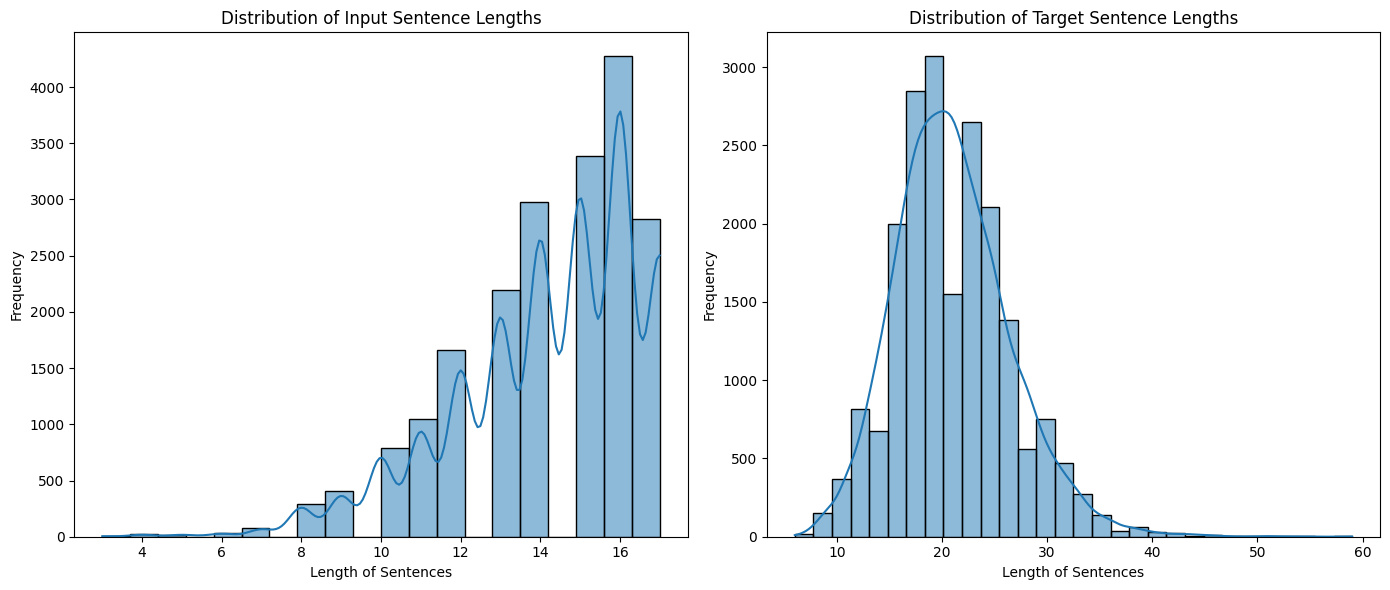

In [ ]:
"""## 4. 탐색적 데이터 분석 (EDA)"""

# 샘플 데이터 확인
print("\n--- Sample Data ---")
for i in range(5):
    print(f"Input: {input_texts[i]} / Target: {target_texts[i].strip()}")

# 문장 길이 분포 시각화
input_lengths = [len(txt) for txt in input_texts]
target_lengths = [len(txt) for txt in target_texts]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(input_lengths, bins=20, kde=True)
plt.title('Distribution of Input Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(target_lengths, bins=30, kde=True)
plt.title('Distribution of Target Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


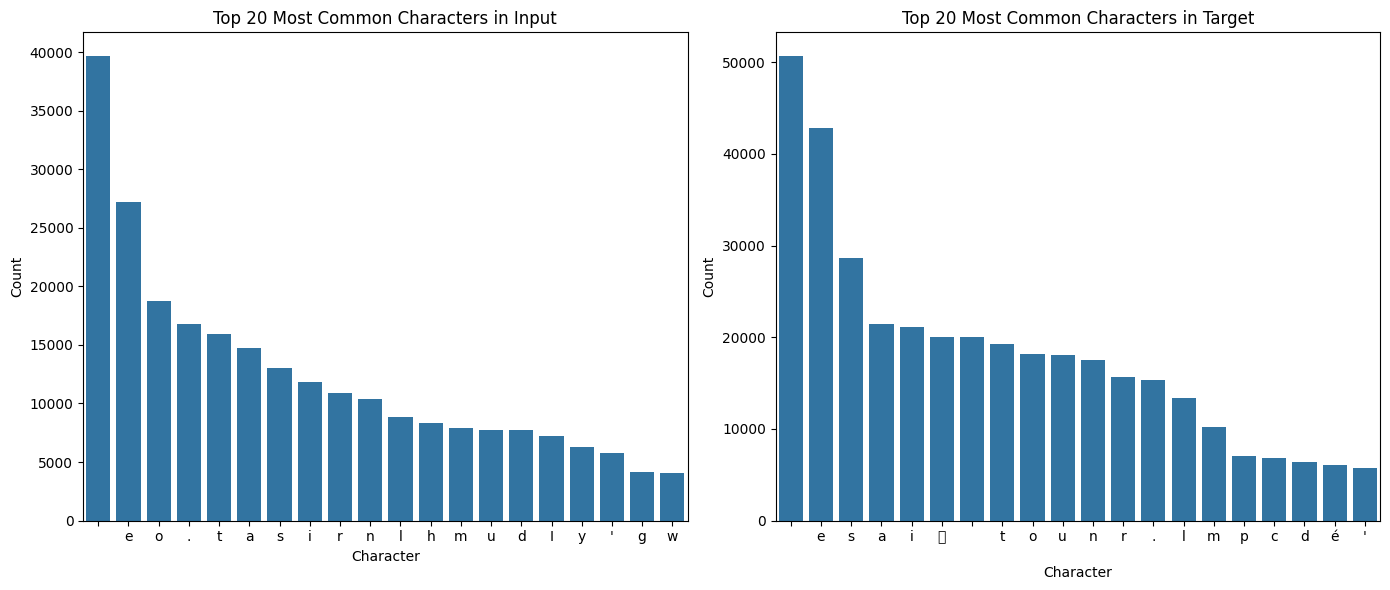

In [ ]:
# 문자 빈도 분석
input_char_counts = Counter("".join(input_texts))
target_char_counts = Counter("".join(target_texts))

# 가장 흔한 문자 20개 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
common_input_chars = pd.DataFrame(input_char_counts.most_common(20), columns=['Character', 'Count'])
sns.barplot(x='Character', y='Count', data=common_input_chars)
plt.title('Top 20 Most Common Characters in Input')

plt.subplot(1, 2, 2)
common_target_chars = pd.DataFrame(target_char_counts.most_common(20), columns=['Character', 'Count'])
sns.barplot(x='Character', y='Count', data=common_target_chars)
plt.title('Top 20 Most Common Characters in Target')

plt.tight_layout()
plt.show()

In [ ]:
"""## 5. 데이터 벡터화"""

# 모델 입력을 위한 제로 행렬 초기화
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 각 문장을 원-핫 인코딩하여 행렬에 채움
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [ ]:
"""## 6. Seq2Seq 모델 구축"""

# 인코더 정의
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c] # 인코더의 최종 상태 (컨텍스트 벡터)

# 디코더 정의
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) # 인코더 상태를 초기 상태로 사용
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 전체 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 모델 컴파일
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 74)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 100) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    338,944 │ input_layer[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    365,568 │ input_layer_1[0]… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 100) │     25,700 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 730,212 (2.79 MB)

 Trainable params: 730,212 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""## 7. 모델 학습"""

# 콜백 설정: 조기 종료 및 모델 체크포인트
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('s2s_translation.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 모델 학습
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.2,
          callbacks=[early_stopping, model_checkpoint])

246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7434 - loss: 0.9237
Epoch 1: val_loss improved from inf to 0.92658, saving model to s2s_translation.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7436 - loss: 0.9228 - val_accuracy: 0.7350 - val_loss: 0.9266


In [ ]:
"""## 8. 결과 분석 및 시각화"""

# 학습 과정 시각화 (Loss 및 Accuracy)
plt.figure(figsize=(14, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
"""## 9. 추론(Inference) 모델 구축"""

# 인코더 모델
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 모델
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# 인덱스를 문자로 변환하기 위한 딕셔너리
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # 입력 시퀀스를 인코딩하여 상태 벡터를 얻음
    states_value = encoder_model.predict(input_seq)

    # 디코더의 첫 입력으로 시작 토큰('<t>')을 준비
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''

    # 종료 조건이 될 때까지 한 글자씩 예측
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 가장 확률이 높은 토큰을 샘플링
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 종료 조건: 최대 길이를 초과하거나 종료 토큰을 만나면
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 다음 타임스텝을 위해 현재 토큰을 입력으로 설정
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태 업데이트
        states_value = [h, c]

    return decoded_sentence

In [ ]:
"""## 10. 번역 결과 확인"""

# 학습 데이터셋의 일부를 사용하여 번역 결과 테스트
print("\n--- Translation Test ---")
for seq_index in range(100, 120):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence.strip())